In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.signal import fftconvolve
import dask.array as da
from pulse_pair_doppler import pulse_pair_doppler

In [2]:
model = pulse_pair_doppler(
    t_pulse=1.15e-4,                   # s
    t_receive=20e-4,                # s 
    t_interpulse=0*1e-4,              # s
    # n_reflectors=4,            # -    TODO why does this number increase error?
    # temporal_decorr = 0.98,
    n_pulses=2,                     # -
    n_bursts=35,                    # -
    bandwidth=1e6,                  # hz
    baseband=0,                     # hz   TODO why does this number increase error?
    oversample_retriev=5,           # -    TODO why does this number increase error?
    range_cell_avg_factor=3,        # -
    range_cell_size_frac_pulse=1,   # -
    seed=12,                         # -
)

model.chirp(centre_around_baseband=True).pulse_pairs()

pulse_pair_doppler(t_pulse=0.000115, t_receive=0.002, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, temporal_decorr=False, n_reflectors=None, oversample_retriev=5, range_cell_avg_factor=3, range_cell_size_frac_pulse=1)

In [3]:
# TODO fix chunk size at start
# TODO Have reflection be sampled at same temporal resolution as pulse
# TODO calculate pulses individually or somehow calculate reflection per pulse after groupby
# TODO calculate range and distance not from x and y, but of x and y and some array that adds a constant small offset per cell (mimicking that scatterers are not equally spaced)
# NOTE flox installed in environment to speed up groupby

In [4]:
c = 3e8
res_az = 150 # m   TODO find resolution along azimuth
res_rg = 150 # m   TODO make function of bandwith
n_scatterers_per_cell = 1
extent_rg = 0.150e3 #600e3 # m 
extent_az = 0.150e3 # m
incidence_min = 29 # deg
x0, y0, z0 = 0, 0, 700e3 # m azimuth, range, altitude satellite
PRF = 5 # / s
distance_satellite = 25e3 # m 
vy_satellite, vx_satellite, vz_satellite = 0, 6800, 0 # m /s
n_bursts = int(np.floor(distance_satellite / vx_satellite * PRF))

n_scatterers_az = int(extent_az / res_az * n_scatterers_per_cell)
n_scatterers_rg = int(extent_rg / res_rg * n_scatterers_per_cell)

min_rg = np.tan(np.deg2rad(incidence_min))*z0
max_rg = min_rg + extent_rg
min_az, max_az = -extent_az/2, extent_az /2

seed = 42
np.random.seed(seed)
chunk_az = 1
chunk_rg = 50
chunk_time_slow = 1
chunk_pulse_time = -1

rg_extent = da.from_array(np.linspace(start=min_rg, stop=max_rg, num=n_scatterers_rg), chunks = (chunk_rg))
az_extent = da.from_array(np.linspace(start=min_az, stop=max_az, num=n_scatterers_az), chunks = (chunk_az))

rg, az = np.meshgrid(rg_extent, az_extent)

In [5]:
time_slow = np.linspace(start=0, stop=n_bursts/PRF ,num=n_bursts)

# TODO undo
amplitude = da.from_array(np.random.rayleigh(scale=1, size=(rg.shape[0], rg.shape[1],  len(time_slow))), chunks=(chunk_az, chunk_rg, chunk_time_slow))
# t = np.zeros(shape=(rg.shape[0], rg.shape[1],  len(time_slow)))
# t[0, 2000, :] = 1
# t[0, 1500, :] = 1
# t[0, 1000, :] = 1
# amplitude = da.from_array(t, chunks=(chunk_az, chunk_rg, chunk_time_slow))


# TODO add offset again
# spatial_grid_offset_rg = da.from_array(np.random.uniform(low=-res_rg/2/n_scatterers_per_cell, high =res_rg/2/n_scatterers_per_cell, size= (rg.shape[0], rg.shape[1])), chunks=(chunk_az, chunk_rg))
# spatial_grid_offset_az = da.from_array(np.random.uniform(low=-res_az/2/n_scatterers_per_cell, high =res_az/2/n_scatterers_per_cell, size= (rg.shape[0], rg.shape[1])), chunks=(chunk_az, chunk_rg))
spatial_grid_offset_rg = np.zeros_like(rg)
spatial_grid_offset_az = np.zeros_like(az)


uniform_phase = da.from_array(np.random.rand(amplitude.size).reshape(amplitude.shape), chunks = (chunk_az, chunk_rg, chunk_time_slow))
scatter_phase = np.exp(1j*uniform_phase*2*np.pi)
velocity = np.ones_like(amplitude)

x_sat = x0 + time_slow * vx_satellite
y_sat = y0 + time_slow * vy_satellite
z_sat = z0 + time_slow * vz_satellite

In [6]:
ds = xr.Dataset(
    data_vars=dict(
        amplitude=(["x", "y", "time_slow"], amplitude), 
        spatial_grid_offset_rg=(["x", "y"], spatial_grid_offset_rg), 
        spatial_grid_offset_az=(["x", "y"], spatial_grid_offset_az), 
        velocity=(["x", "y", "time_slow"], velocity),
        scatter_phase=(["x", "y", "time_slow"], scatter_phase),
        # TODO add beam pattern 
        # TODO add realistic gradient based on CMOD
        x_sat=(["time_slow"], x_sat),
        y_sat=(["time_slow"], y_sat),
        z_sat=(["time_slow"], z_sat),

    ),
    coords=dict(
        rg=(["x", "y"], rg),
        az=(["x", "y"], az),
        time_slow=(["time_slow"], time_slow),
    ),
    attrs=dict(description="Simulated surface", 
               vx_sat=vx_satellite, 
))
ds

<xarray.Dataset>
Dimensions:                 (x: 1, y: 1, time_slow: 18)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
Dimensions without coordinates: x, y
Data variables:
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    x_sat                   (time_slow) float64 0.0 1.44e+03 ... 2.448e+04
    y_sat                   (time_slow) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    z_sat                   (time_slow) float64 7e+05 7e+05 ... 7e+05 7e+05
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [15]:
def calculate_distance(x, y, x0=0 , y0=0, x_offset=0, y_offset=0):
    return np.sqrt((x - x0 + x_offset) ** 2 + (y - y0 + y_offset) ** 2)

ds['d_ground'] = calculate_distance(ds['az'], ds['rg'], ds['x_sat'], ds['y_sat'], ds['spatial_grid_offset_az'], ds['spatial_grid_offset_rg'])
ds['R'] = calculate_distance(ds['d_ground'], ds['z_sat'])

pulse_time = xr.DataArray(np.linspace(0, model.t_pulse, model.pulse_samples), dims='pulse_time').chunk({'pulse_time':chunk_pulse_time})
pulse = xr.DataArray(model.pulse, dims='pulse_time').chunk({'pulse_time':chunk_pulse_time})

ds['travel_time'] = ds['R']/c
t_min = ds['travel_time'].min().values*1
t_max = ds['travel_time'].max().values*1 + model.t_pulse
n_reflection_samples = int(np.ceil((t_max - t_min)*model.fs))
bins = np.linspace(t_min, t_max, n_reflection_samples)

t = ds.groupby_bins(group=ds['travel_time'], bins=bins)

In [109]:
time_fast = xr.DataArray(bins, dims='time_fast').chunk({'time_fast':chunk_pulse_time})
# time_fast = ds.rg*ds.az*time_fast

ds = ds.assign_coords({"time_fast": time_fast})

amplitude2 = da.from_array(np.random.rayleigh(scale=1, size=(rg.shape[0], rg.shape[1],  len(time_slow), time_fast.shape[0])), chunks=(chunk_az, chunk_rg, chunk_time_slow, chunk_pulse_time))
ds['amplitude2'] = (["x", "y", "time_slow", "time_fast"], amplitude2)
ds

<xarray.Dataset>
Dimensions:                 (x: 1, y: 4000, time_slow: 18, time_fast: 7421)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
  * time_fast               (time_fast) float64 0.002668 0.002668 ... 0.004152
Dimensions without coordinates: x, y
Data variables:
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    x_sat                   (time_slow) float64 0.0 1.44e+03 ... 2.448e+04
    y_sat                   (time_slow) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    z_sat                   (time_slow) float64 7e+05 7e+05 ... 7e+05 7e+05
    d_ground                (x, y, time_slow) float64 dask.array<chunksize=(1, 50, 18), meta=np.ndarray>
    R                       (x, y, time_slow) float64 dask.array<chunksize=(1, 50, 18), meta=np.ndarray>
    travel_time             (x, y, time_slow) float64 dask.array<chunksize=(1, 50, 18), meta=np.ndarray>
    amplitude2              (x, y, time_slow, time_fast) float64 dask.array<chunksize=(1, 50, 1, 7421), meta=np.ndarray>
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [40]:
B = da.digitize(ds["travel_time"].data, bins)
A = ds[['amplitude2']].where(B.notnull(), other=0)

AttributeError: 'Array' object has no attribute 'notnull'

In [7]:
def calculate_distance(x, y, x0=0 , y0=0, x_offset=0, y_offset=0):
    return np.sqrt((x - x0 + x_offset) ** 2 + (y - y0 + y_offset) ** 2)

ds['d_ground'] = calculate_distance(ds['az'], ds['rg'], ds['x_sat'], ds['y_sat'], ds['spatial_grid_offset_az'], ds['spatial_grid_offset_rg'])
ds['R'] = calculate_distance(ds['d_ground'], ds['z_sat'])


travel_time = ds['R']/c
t_min = travel_time.min().values*1
t_max = travel_time.max().values*1 + model.t_pulse
n_reflection_samples = int(np.ceil((t_max - t_min)*model.fs))
bins = np.linspace(t_min, t_max, n_reflection_samples)


pulse_time_vector = np.append(np.linspace(0, model.t_pulse, model.pulse_samples), np.zeros(len(bins) - model.pulse_samples))
pulse_vector = np.append(model.pulse, np.zeros(len(bins) - model.pulse_samples))
pulse_time = xr.DataArray(pulse_time_vector, dims='pulse_time').chunk({'pulse_time':chunk_pulse_time})
pulse = xr.DataArray(pulse_vector, dims='pulse_time').chunk({'pulse_time':chunk_pulse_time})


ds['fast_time'] = travel_time + pulse_time
ds['reflection'] = ds['amplitude'] * ds['scatter_phase'] * pulse 
ds = ds.chunk({'x': chunk_az, 'y': chunk_rg, 'time_slow': chunk_time_slow, 'pulse_time':chunk_pulse_time})
ds

<xarray.Dataset>
Dimensions:                 (x: 1, y: 1, time_slow: 18, pulse_time: 1163)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
Dimensions without coordinates: x, y, pulse_time
Data variables:
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    x_sat                   (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    y_sat                   (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    z_sat                   (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    d_ground                (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    R                       (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    fast_time               (x, y, time_slow, pulse_time) float64 dask.array<chunksize=(1, 1, 1, 1163), meta=np.ndarray>
    reflection              (x, y, time_slow, pulse_time) complex128 dask.array<chunksize=(1, 1, 1, 1163), meta=np.ndarray>
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [54]:
a, b = np.unique(t.fast_time.isel(time_slow=0), return_inverse=True)

a.shape, b

((1150,), array([0, 1, 2, ..., 0, 0, 0]))

In [37]:
t = ds[['reflection', 'fast_time']].set_coords('fast_time').unstack()
t.where(t.fast_time == bins[4]).sum().compute()

<xarray.Dataset>
Dimensions:     ()
Data variables:
    reflection  complex128 0j

In [10]:
ds['travel_time'] = ds['R']/c
B = da.digitize(ds["travel_time"].data, bins, right = True)
ds['bin'] = (['x', 'y', 'time_slow'], B)
ds

<xarray.Dataset>
Dimensions:                 (x: 1, y: 1, time_slow: 18, pulse_time: 1163)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
Dimensions without coordinates: x, y, pulse_time
Data variables: (12/14)
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    x_sat                   (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                      ...
    d_ground                (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    R                       (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    fast_time               (x, y, time_slow, pulse_time) float64 dask.array<chunksize=(1, 1, 1, 1163), meta=np.ndarray>
    reflection              (x, y, time_slow, pulse_time) complex128 dask.array<chunksize=(1, 1, 1, 1163), meta=np.ndarray>
    travel_time             (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    bin                     (x, y, time_slow) int64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [60]:
time_fast = xr.DataArray(bins, dims='time_fast').chunk({'time_fast':chunk_pulse_time})
ds.sel(time_slow=0, x=0, y=0).reflection
ds = ds.assign_coords({"time_fast": time_fast})
ds


<xarray.Dataset>
Dimensions:                 (x: 1, y: 1, time_slow: 18, pulse_time: 1150,
                             time_fast: 1163)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118 0.4235 ... 3.388 3.6
  * time_fast               (time_fast) float64 0.002668 0.002668 ... 0.002784
Dimensions without coordinates: x, y, pulse_time
Data variables: (12/14)
    amplitude               (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    velocity                (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) complex128 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    x_sat                   (time_slow) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                      ...
    d_ground                (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    R                       (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    fast_time               (x, y, time_slow, pulse_time) float64 dask.array<chunksize=(1, 1, 1, 1150), meta=np.ndarray>
    reflection              (x, y, time_slow, pulse_time) complex128 dask.array<chunksize=(1, 1, 1, 1150), meta=np.ndarray>
    travel_time             (x, y, time_slow) float64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    bin                     (x, y, time_slow) int64 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes:
    description:  Simulated surface
    vx_sat:       6800

In [96]:
ds.bin[0,0, :].compute().values[0]

0

In [109]:
B

dask.array<digitize, shape=(1, 1, 18), dtype=int64, chunksize=(1, 1, 1), chunktype=numpy.ndarray>

In [107]:
idx = ds.bin[0,0, :].compute().values[8]
ds['reflection_sorted'][:,:,8,idx: idx + len(ds.pulse_time)] = ds.reflection[:,:,8, :]

In [ ]:
ds.reflection_sorted.iloc[{'time_slow': ]

In [108]:
chunk_time_fast = -1
reflection_sorted = da.from_array(np.zeros(shape=(rg.shape[0], rg.shape[1],  len(ds.time_slow), len(ds.time_fast))), chunks=(chunk_az, chunk_rg, chunk_time_slow, chunk_time_fast))
ds['reflection_sorted'] = (['x', 'y', 'time_slow', 'time_fast'], reflection_sorted)
ds['reflection_sorted']

<xarray.DataArray 'reflection_sorted' (x: 1, y: 1, time_slow: 18,
                                       time_fast: 1163)>
dask.array<array, shape=(1, 1, 18, 1163), dtype=float64, chunksize=(1, 1, 1, 1163), chunktype=numpy.ndarray>
Coordinates:
    rg         (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    az         (x, y) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * time_slow  (time_slow) float64 0.0 0.2118 0.4235 0.6353 ... 3.176 3.388 3.6
  * time_fast  (time_fast) float64 0.002668 0.002668 ... 0.002784 0.002784
Dimensions without coordinates: x, y

In [16]:
new_dtype = 'float32'

# Create a new Dataset with the modified datatypes
ds = xr.Dataset({
    k: (v.astype('complex64') if v.dtype == 'complex128' else v.astype(new_dtype))
    for k, v in ds.data_vars.items()
})

ds = ds.isel(time_slow=range(0,2))#, y=range(0,12000))#, x=range(0,100))
ds

<xarray.Dataset>
Dimensions:                 (x: 1, y: 4000, time_slow: 2, pulse_time: 1150)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
  * time_slow               (time_slow) float64 0.0 0.2118
Dimensions without coordinates: x, y, pulse_time
Data variables:
    amplitude               (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float32 dask.array<chunksize=(1, 50), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float32 dask.array<chunksize=(1, 50), meta=np.ndarray>
    velocity                (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    scatter_phase           (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    x_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    y_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    z_sat                   (time_slow) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    d_ground                (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    R                       (x, y, time_slow) float32 dask.array<chunksize=(1, 50, 1), meta=np.ndarray>
    fast_time               (x, y, time_slow, pulse_time) float32 dask.array<chunksize=(1, 50, 1, 1150), meta=np.ndarray>
    reflection              (x, y, time_slow, pulse_time) complex64 dask.array<chunksize=(1, 50, 1, 1150), meta=np.ndarray>

In [17]:
# import dask.distributed
# client = dask.distributed.Client()
# client

In [18]:
# ds["index_digi"] = (["x", "y", "time_slow", "pulse_time"], da.digitize(ds["fast_time"].data, bins).astype('int32'))

In [19]:
# ds["index_digi"] = da.digitize(ds["fast_time"].data, bins).astype('int32').chunk({'x': chunk_az, 'y': chunk_rg, 'time_slow': chunk_time_slow, 'pulse_time':chunk_pulse_time})

In [20]:
# def searchsort_custom(da, bins):
#     return np.searchsorted(bins, da)

# ds["index_digi"] = ds[["fast_time"]].apply(searchsort_custom, bins=bins).fast_time.astype('int32').chunk({'x': chunk_az, 'y': chunk_rg, 'time_slow': chunk_time_slow, 'pulse_time':chunk_pulse_time})

In [21]:
# ds_sub = ds.isel(time_slow=0)
# reflections_grouped = ds_sub['reflection'].groupby(ds_sub['index_digi'])
# reflection_total = reflections_grouped.sum().compute()

ds = ds[['reflection', 'fast_time']].isel(time_slow=0)
grouped = ds.groupby_bins(group = ds['fast_time'], bins= bins).sum().compute()
total_reflection = grouped.reflection
model.reflections = total_reflection.where(np.isfinite(total_reflection), other=0)

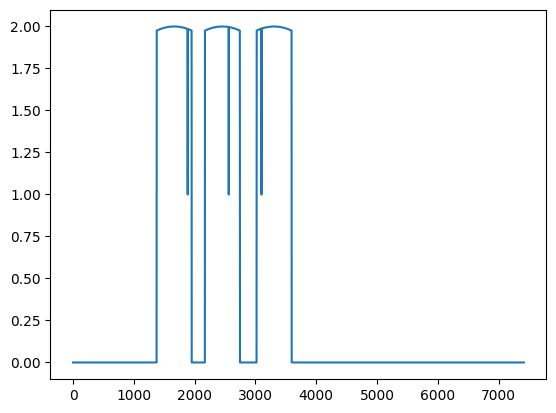

In [22]:
plt.plot(abs(total_reflection))

In [33]:
# to store results

# xr.Dataset(
#     data_vars=dict(
#         ref_real=(["t"], total_reflection.values.real), 
#         ref_imag=(["t"], total_reflection.values.imag), 

#     ),
#     coords=dict(
#         t=(["t", ], np.array([i.left for i in total_reflection.fast_time_bins.values])),
#     ),).to_netcdf('surface_test.nc')

total_reflection = xr.open_dataset('surface_test.nc')
total_reflection = np.array([complex(a, b) for a,b in zip(total_reflection.ref_real.values,  total_reflection.ref_imag.values)])
total_reflection = np.where(np.isfinite(total_reflection), total_reflection, 0)
model.reflections = total_reflection

In [17]:
model.pulse_compress()
model.delayed_autocorrelation()
model.phase_difference()

Autocorrelation cell: 100%|██████████| 10/10 [00:00<00:00, 3536.21it/s]


pulse_pair_doppler(t_pulse=0.000115, t_receive=0.002, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, temporal_decorr=False, n_reflectors=None, oversample_retriev=10, range_cell_avg_factor=3, range_cell_size_frac_pulse=1)

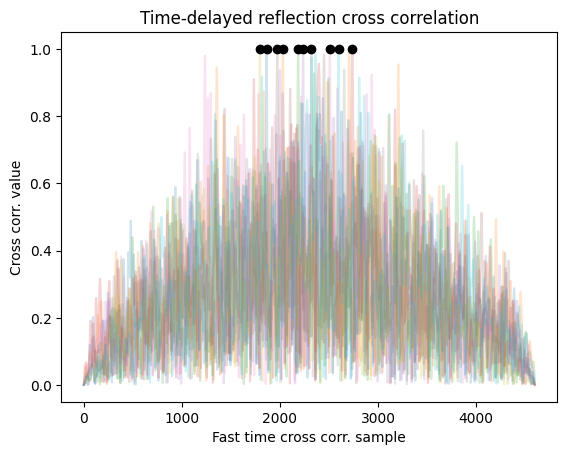

In [18]:
sig = abs(model.corr.T)
sig /= np.max(sig, axis = 0)
peaks = np.argmax(sig, axis = 0)

plt.figure()
plt.title("Time-delayed reflection cross correlation"); plt.xlabel("Fast time cross corr. sample"); plt.ylabel("Cross corr. value"); 
plt.plot(sig, alpha = 0.2, zorder = 1)
plt.scatter(peaks, sig[peaks, np.arange(len(model.corr))], c = 'k', zorder =2)

In [19]:
if model.n_reflectors is not None:
    # arb_cross_corr_limit = np.min(np.sort(np.max(sig, axis = 0), axis=0)[-model.n_reflectors:])
    # phase_diff = model.phase_diff_avg_rg[sig.max(axis= 0) >= arb_cross_corr_limit]
    wvc_cell = np.unique(np.where(abs(model.surface) > 0)[0] // len(model.pulse) - 2 )
    wvc_cell = wvc_cell[(wvc_cell>=0) & (wvc_cell< len(model.phase_diff_avg_rg))]
    phase_diff = model.phase_diff_avg_rg[wvc_cell]
    print(f"WVC: {wvc_cell}, \nwith phase diff.: \n{phase_diff}")
else:
    phase_diff = model.phase_diff_avg_rg

phase_diff_rmse = np.sqrt(np.mean(phase_diff**2))

c = 3e8 # m/s
Lambda = 0.05 # c/f # m
t_delta = model.t_pulse + model.t_interpulse

LoS_velocity_phase = phase_diff * Lambda / (2*np.pi * t_delta)
LoS_velocity_phase_rmse = phase_diff_rmse * Lambda / (2*np.pi * t_delta)

print(f"\n RMSE phase error of: {phase_diff_rmse:.4f} rad, which is equal to {LoS_velocity_phase_rmse:.3f} m/s ")


 RMSE phase error of: 0.5330 rad, which is equal to 36.886 m/s 


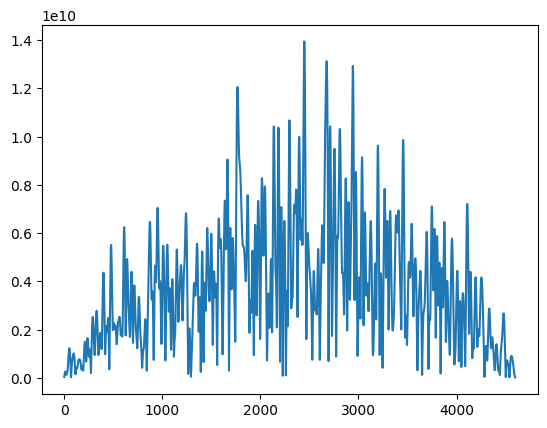

In [21]:
t = fftconvolve(model.reflections, model.pulse)

window_size = int(model.pulse_samples // (1 / model.range_cell_size_frac_pulse)) 
step_size = model.pulse_samples + model.interpulse_samples
N = 20600
plt.plot(abs(fftconvolve(t[N:N+window_size], t[N+window_size:N+2*window_size])))

## Test without numpy

In [82]:
pulse = np.linspace(1, 200, 200)
from scipy.signal import fftconvolve

data_variable = ds['amplitude']
kernel_variable = ds['pulse']

convolved_data = xr.apply_ufunc(
    fftconvolve,
    data_variable,
    kernel_variable,
    input_core_dims=[['x', 'y', 'time_slow'], ['time_fast']],
    output_core_dims=[['x', 'y', 'time_slow', 'time_fast']],
    vectorize=True,
    dask='parallelized',  # Use Dask for parallel processing if available
    output_dtypes=[float],
    output_sizes={
        'x': len(data_variable['x']),
        'y': len(data_variable['y']),
        'time_slow': len(data_variable['time_slow']),
        'time_fast': len(kernel_variable['time_fast']),
    }
)

## Testing offset

In [36]:
import xarray as xr
import numpy as np

t = np.random.rand(10, 10, 10)
ds = xr.Dataset(
    data_vars=dict(
        reflection_local=(["x", "y", "t_local"], t), 
        reflection_local_offset=([''], t),
        # local_global_offset=(["x", "y"], np.random.randint(0, 100, size=(10, 10))), 

    ),
    coords=dict(
        x=(["x"], np.arange(10)),
        y=(["y"], np.arange(10)),
        t_local=(["t_local"], np.arange(10)),
        t_global=(["t_global"], np.arange(100)),
        offset = (['x', 'y'], np.random.randint(0, 100, size=(10, 10)))
    ),
)

ds

ValueError: Variable 'reflection_local': Could not convert tuple of form (dims, data[, attrs, encoding]): (['x', 'y', 't_local', 'offset'], array([[[0.23523753, 0.68079233, 0.895791  , 0.75494197, 0.83479154,
         0.78138377, 0.97914767, 0.75780493, 0.21022852, 0.79159847],
        [0.32206936, 0.99579986, 0.37667262, 0.29279376, 0.23921599,
         0.65851465, 0.10922109, 0.95355988, 0.29431268, 0.29540061],
        [0.0460661 , 0.24601752, 0.41897936, 0.36960639, 0.27301992,
         0.04074384, 0.30058137, 0.77833094, 0.43879229, 0.29077535],
        [0.30479213, 0.55443758, 0.30229268, 0.63079732, 0.98945451,
         0.0411764 , 0.16873676, 0.17910755, 0.44707032, 0.04141871],
        [0.47752158, 0.92892476, 0.01156409, 0.36493887, 0.76089377,
         0.1544945 , 0.077559  , 0.63077854, 0.00995091, 0.80177049],
        [0.06685275, 0.52435426, 0.74012771, 0.24201099, 0.10354016,
         0.17562277, 0.85468357, 0.70578029, 0.19809805, 0.7161208 ],
        [0.70861817, 0.9977251 , 0.39155602, 0.86485349, 0.44644269,
         0.89776022, 0.0916005 , 0.17531263, 0.84995436, 0.81930032],
        [0.30543379, 0.59679832, 0.38269972, 0.01031735, 0.02610413,
         0.05425637, 0.59407215, 0.27922774, 0.1439483 , 0.94113111],
        [0.12131867, 0.67398172, 0.89416018, 0.16382967, 0.21472968,
         0.57381353, 0.50844869, 0.52102742, 0.55467809, 0.94990292],
        [0.05383804, 0.76044852, 0.23250642, 0.37367767, 0.08929112,
         0.44562677, 0.80421925, 0.09874034, 0.2756036 , 0.37306171]],

       [[0.1038992 , 0.76231681, 0.78694703, 0.835895  , 0.5838962 ,
         0.50723882, 0.26255245, 0.65515797, 0.44456349, 0.97077641],
        [0.9681795 , 0.90520513, 0.36008914, 0.36797246, 0.85267316,
         0.72913493, 0.70436097, 0.27961101, 0.83334861, 0.57942057],
        [0.44686557, 0.86542212, 0.39420976, 0.65392581, 0.46590518,
         0.59273781, 0.04054647, 0.46111516, 0.55649131, 0.49271933],
        [0.84741037, 0.31112397, 0.88407653, 0.40346197, 0.69452673,
         0.08672273, 0.20015408, 0.76116601, 0.01232869, 0.96852774],
        [0.1906289 , 0.90130399, 0.51594503, 0.56457537, 0.08413179,
         0.36521875, 0.15621886, 0.52593149, 0.55073215, 0.70966695],
        [0.87827816, 0.46817982, 0.23336037, 0.33357166, 0.84708981,
         0.14586349, 0.62725608, 0.01308588, 0.24566933, 0.5914085 ],
        [0.45641204, 0.49354949, 0.66056205, 0.23458602, 0.28080494,
         0.68445821, 0.53829141, 0.01458682, 0.6703278 , 0.62009204],
        [0.07860757, 0.74751949, 0.52210146, 0.20474728, 0.55935637,
         0.59545851, 0.92011873, 0.74214443, 0.30192435, 0.11813297],
        [0.85318407, 0.84606769, 0.17531001, 0.06213119, 0.71186465,
         0.72258183, 0.17714375, 0.66821186, 0.27892374, 0.26061703],
        [0.32451793, 0.52039637, 0.80445392, 0.49864375, 0.2980427 ,
         0.8839743 , 0.05508996, 0.79709148, 0.78438176, 0.25354681]],

       [[0.19829518, 0.87470056, 0.55887129, 0.04601136, 0.89083252,
         0.34900598, 0.34215655, 0.64328794, 0.66131094, 0.35331612],
        [0.14327893, 0.55226976, 0.62517916, 0.86022237, 0.48443999,
         0.64569608, 0.05440883, 0.8945229 , 0.32721581, 0.63222112],
        [0.91605163, 0.81052578, 0.63770386, 0.70360783, 0.92090512,
         0.81209318, 0.60985906, 0.65870271, 0.14726842, 0.47016768],
        [0.30099765, 0.43197063, 0.66224687, 0.14915109, 0.01737596,
         0.3969244 , 0.32218431, 0.42043206, 0.93122092, 0.7070841 ],
        [0.32745877, 0.17927882, 0.61847829, 0.65757625, 0.48362268,
         0.21276077, 0.02855526, 0.2656607 , 0.4571705 , 0.78793429],
        [0.85375383, 0.41293456, 0.79612405, 0.99335282, 0.71661037,
         0.72859903, 0.9095365 , 0.33814413, 0.01120539, 0.98697727],
        [0.49046808, 0.78567759, 0.81249114, 0.39751668, 0.54127305,
         0.53991553, 0.22021601, 0.11763893, 0.5435723 , 0.12014323],
        [0.34608872, 0.18608333, 0.70691611, 0.87200885, 0.57791461,
         0.41015581, 0.99664264, 0.02120914, 0.30434108, 0.27867315],
        [0.3562036 , 0.23059574, 0.26426284, 0.25767711, 0.50574405,
         0.39105528, 0.6392801 , 0.51440116, 0.18342185, 0.81004498],
        [0.4721952 , 0.15323152, 0.16687984, 0.79696841, 0.70299318,
         0.50652795, 0.30608151, 0.46052204, 0.63648354, 0.87928232]],

       [[0.55586787, 0.27673529, 0.04273991, 0.17545506, 0.65017762,
         0.16043697, 0.48153955, 0.69895502, 0.3082249 , 0.66910589],
        [0.58107206, 0.43893911, 0.89724548, 0.69205889, 0.36059703,
         0.80426453, 0.73810221, 0.79168397, 0.64095598, 0.37937062],
        [0.34857852, 0.65415136, 0.13090001, 0.81991435, 0.37033538,
         0.63037199, 0.49906391, 0.51932649, 0.73800615, 0.62667005],
        [0.25030899, 0.07422593, 0.84023407, 0.88489407, 0.16449653,
         0.30947707, 0.28234238, 0.93744856, 0.20477738, 0.16653923],
        [0.18183855, 0.72986918, 0.88801984, 0.39336741, 0.1360799 ,
         0.585722  , 0.20993496, 0.06415145, 0.88623138, 0.87084128],
        [0.97591016, 0.47400475, 0.2940012 , 0.76978375, 0.18049493,
         0.24329208, 0.25568263, 0.95161941, 0.72982292, 0.13369479],
        [0.09284588, 0.84281485, 0.80227432, 0.67099458, 0.19610065,
         0.48028354, 0.60272595, 0.93213753, 0.16942374, 0.51544681],
        [0.15775164, 0.44384934, 0.20013497, 0.83618621, 0.25473628,
         0.41710472, 0.40778765, 0.86629496, 0.75779746, 0.05757549],
        [0.06708746, 0.55119725, 0.42771903, 0.27558422, 0.79262094,
         0.12863517, 0.97405691, 0.02410251, 0.11823072, 0.31131665],
        [0.5091491 , 0.21613616, 0.73621515, 0.3575419 , 0.03853833,
         0.87772197, 0.94386567, 0.61856362, 0.80653639, 0.12111154]],

       [[0.26882028, 0.32523169, 0.96075317, 0.51222264, 0.00741356,
         0.38018582, 0.0077506 , 0.23780574, 0.45470007, 0.32339306],
        [0.03273421, 0.11633572, 0.55088656, 0.6956049 , 0.40454901,
         0.73148175, 0.16333289, 0.12205795, 0.83945372, 0.33921335],
        [0.43224792, 0.9475816 , 0.42411233, 0.00349011, 0.93797194,
         0.01411863, 0.66228628, 0.32289091, 0.47039076, 0.54728517],
        [0.40846006, 0.77436879, 0.93070641, 0.08641205, 0.80025288,
         0.12867114, 0.08027718, 0.95583145, 0.48929778, 0.15260329],
        [0.56995711, 0.26323714, 0.46430902, 0.62465959, 0.86926983,
         0.0030814 , 0.21414066, 0.09627054, 0.0970977 , 0.94577741],
        [0.93608293, 0.74930808, 0.64306304, 0.84797045, 0.05840874,
         0.11948579, 0.31711292, 0.83249238, 0.47223254, 0.50357476],
        [0.22926543, 0.64838748, 0.88784215, 0.32951422, 0.61918594,
         0.33194896, 0.79271911, 0.47495974, 0.33946902, 0.42004885],
        [0.09122752, 0.86611715, 0.95806906, 0.47741418, 0.22133721,
         0.6646562 , 0.45238148, 0.25230008, 0.03843314, 0.88970445],
        [0.79673435, 0.82900606, 0.43983973, 0.75325539, 0.58122526,
         0.3747753 , 0.84274209, 0.99875755, 0.89928231, 0.77619197],
        [0.74750797, 0.65024884, 0.8536175 , 0.49308125, 0.18172951,
         0.76804972, 0.91950637, 0.34135229, 0.7829833 , 0.2737227 ]],

       [[0.94260027, 0.68346099, 0.56927599, 0.77987016, 0.81323117,
         0.8923699 , 0.90111953, 0.05269083, 0.12290761, 0.82606088],
        [0.94605165, 0.30767185, 0.00860182, 0.32270519, 0.38286414,
         0.76103336, 0.04758467, 0.21264024, 0.89396859, 0.15482041],
        [0.75924765, 0.36131042, 0.66266021, 0.0738465 , 0.28655795,
         0.42478974, 0.85721263, 0.56349586, 0.04522529, 0.80186657],
        [0.05452149, 0.93436656, 0.21171745, 0.48792614, 0.07228097,
         0.56171239, 0.4972287 , 0.41024853, 0.03557292, 0.87893638],
        [0.8026366 , 0.63303002, 0.57222998, 0.69494643, 0.14399002,
         0.93264425, 0.28467329, 0.65649027, 0.60675568, 0.63661398],
        [0.87895212, 0.29591121, 0.74894819, 0.59839106, 0.07606033,
         0.41415468, 0.83795157, 0.31534739, 0.48226388, 0.48863857],
        [0.61800987, 0.88401786, 0.1735392 , 0.50461688, 0.42426726,
         0.29592009, 0.91960818, 0.00817109, 0.12210479, 0.73334445],
        [0.2634416 , 0.72317926, 0.83225361, 0.25461602, 0.19194429,
         0.14530063, 0.20008861, 0.26718539, 0.86874982, 0.77000441],
        [0.00184432, 0.87411914, 0.0788123 , 0.65526562, 0.15147477,
         0.06227581, 0.7597707 , 0.46720311, 0.59906251, 0.42535302],
        [0.06717186, 0.73961817, 0.82035112, 0.04142054, 0.3757172 ,
         0.55731654, 0.60518342, 0.57815294, 0.69294065, 0.9668162 ]],

       [[0.39058652, 0.55662357, 0.69907863, 0.59242382, 0.38675103,
         0.62407929, 0.65011153, 0.58496848, 0.20511066, 0.50598136],
        [0.88435681, 0.86860188, 0.75078792, 0.69719551, 0.15327914,
         0.45946466, 0.11095131, 0.81728445, 0.29104321, 0.76686586],
        [0.81457889, 0.8924961 , 0.75383008, 0.564729  , 0.59818491,
         0.32058228, 0.17699619, 0.1306362 , 0.18202352, 0.93395189],
        [0.16443325, 0.72373744, 0.18462854, 0.97528977, 0.36658454,
         0.41213643, 0.40451158, 0.81645918, 0.21829052, 0.83102474],
        [0.65705885, 0.22028017, 0.06540755, 0.77499254, 0.21896305,
         0.88906683, 0.12978528, 0.61636456, 0.69216839, 0.65770241],
        [0.31602981, 0.87552352, 0.76980532, 0.51020634, 0.60329303,
         0.56637123, 0.94669858, 0.89641324, 0.23549729, 0.26275978],
        [0.98143807, 0.2365607 , 0.95347932, 0.64975371, 0.05010944,
         0.3357272 , 0.47615407, 0.83309289, 0.32858541, 0.31057831],
        [0.92026326, 0.07903435, 0.55152121, 0.50423927, 0.05733476,
         0.08775922, 0.38196743, 0.13416122, 0.4780719 , 0.60888889],
        [0.69139668, 0.54647007, 0.37966002, 0.12975863, 0.24748541,
         0.41942168, 0.92411448, 0.20260058, 0.41334423, 0.73230886],
        [0.70520335, 0.96559259, 0.1909013 , 0.01651961, 0.32232326,
         0.14969261, 0.54846905, 0.89877906, 0.68822683, 0.13579886]],

       [[0.11609002, 0.91144981, 0.48760955, 0.92367299, 0.73621772,
         0.99334846, 0.87122774, 0.41421219, 0.75822783, 0.47122817],
        [0.23307229, 0.24102926, 0.39732214, 0.11146623, 0.17776628,
         0.50060868, 0.95392248, 0.57768634, 0.40849675, 0.24270032],
        [0.1959013 , 0.65840703, 0.84832532, 0.39885593, 0.55065905,
         0.70672676, 0.05829558, 0.35089705, 0.72975289, 0.68461903],
        [0.05334772, 0.2378185 , 0.67995721, 0.27141604, 0.81441029,
         0.02950486, 0.19034703, 0.28131298, 0.92528983, 0.79631896],
        [0.88414509, 0.44047915, 0.82256209, 0.85349357, 0.39995682,
         0.99446185, 0.85123863, 0.97409697, 0.86649711, 0.77620364],
        [0.94384387, 0.41981924, 0.78333343, 0.21289121, 0.73279385,
         0.78535328, 0.71652441, 0.84981307, 0.41333545, 0.54476813],
        [0.01066741, 0.14605316, 0.64419393, 0.5623172 , 0.19733251,
         0.24346479, 0.3440822 , 0.71641471, 0.6097166 , 0.06957126],
        [0.75993915, 0.26265956, 0.67175968, 0.12336284, 0.99792128,
         0.08033517, 0.74173403, 0.54133036, 0.08593919, 0.02681046],
        [0.36266572, 0.80222393, 0.04115124, 0.70439866, 0.65537628,
         0.26553768, 0.07749204, 0.91532196, 0.3003498 , 0.11138323],
        [0.68151708, 0.21668123, 0.47563076, 0.05040554, 0.99298395,
         0.44762113, 0.99910998, 0.38567488, 0.34785256, 0.91457233]],

       [[0.32946585, 0.43200555, 0.07811044, 0.95546239, 0.08515124,
         0.77118493, 0.53861539, 0.06140514, 0.00170383, 0.93555364],
        [0.7421734 , 0.68643624, 0.43855653, 0.23861379, 0.67986307,
         0.60830107, 0.72634219, 0.36579252, 0.98692376, 0.06700866],
        [0.07970162, 0.91687585, 0.64770643, 0.32633407, 0.76195276,
         0.45277339, 0.02112151, 0.65110367, 0.24311194, 0.11533512],
        [0.22527318, 0.47615788, 0.04985643, 0.88315239, 0.55991802,
         0.29299618, 0.68700485, 0.8042365 , 0.61392463, 0.20249468],
        [0.11028842, 0.8598997 , 0.23468741, 0.02008243, 0.64290211,
         0.15288533, 0.99096982, 0.86973083, 0.60844573, 0.83386564],
        [0.4705357 , 0.78848624, 0.64653355, 0.02864465, 0.94875767,
         0.86091958, 0.95340739, 0.73136593, 0.41206092, 0.20698522],
        [0.17999635, 0.14491625, 0.22060964, 0.55063601, 0.68374506,
         0.31405656, 0.54874697, 0.34125266, 0.69650997, 0.98848622],
        [0.68901697, 0.05903058, 0.47723496, 0.77038749, 0.54224161,
         0.95106303, 0.05477168, 0.29115554, 0.22071811, 0.7676222 ],
        [0.52379307, 0.13834421, 0.28559326, 0.52265932, 0.99612898,
         0.36429236, 0.1568261 , 0.49706653, 0.31018638, 0.56596682],
        [0.4667103 , 0.68948992, 0.91429071, 0.20051435, 0.82118007,
         0.94926572, 0.37360968, 0.1136627 , 0.82191117, 0.70109581]],

       [[0.2127122 , 0.44522359, 0.57799221, 0.16985409, 0.71491283,
         0.68988274, 0.88712661, 0.56727296, 0.57431303, 0.61938736],
        [0.27378326, 0.75860585, 0.66249926, 0.83914563, 0.768586  ,
         0.63857223, 0.16089215, 0.91914732, 0.36721218, 0.96429857],
        [0.4018708 , 0.14593829, 0.88483975, 0.79505874, 0.78629606,
         0.08941075, 0.87927983, 0.59640064, 0.47035574, 0.91317162],
        [0.66604135, 0.13303082, 0.51953718, 0.63661659, 0.8985507 ,
         0.2798941 , 0.79423389, 0.7998129 , 0.12804948, 0.01723318],
        [0.5814097 , 0.78947889, 0.55443082, 0.81334749, 0.62230314,
         0.65329236, 0.02815443, 0.0885982 , 0.72502962, 0.76284328],
        [0.54217798, 0.59016513, 0.61436584, 0.10499132, 0.6679086 ,
         0.47846998, 0.60252298, 0.56314183, 0.76300025, 0.31856826],
        [0.37352625, 0.39160631, 0.7624561 , 0.43111262, 0.17707477,
         0.98304097, 0.49338186, 0.10924808, 0.67027496, 0.73916236],
        [0.50022284, 0.64645722, 0.17267486, 0.36792239, 0.1618286 ,
         0.38723526, 0.56280052, 0.44253941, 0.59321484, 0.50175917],
        [0.31781437, 0.143416  , 0.25267286, 0.20071325, 0.70742229,
         0.81996684, 0.72038861, 0.64373415, 0.30785135, 0.71098556],
        [0.60508346, 0.04689337, 0.90761212, 0.07995384, 0.5027079 ,
         0.51306915, 0.83700719, 0.9130675 , 0.93967579, 0.56967213]]])) to Variable.

In [26]:
def custom_roll(x, y):
    # Use numpy.roll to perform the roll operation along the t_local dimension
    return np.roll(x, shift=y)



# res = xr.apply_ufunc(special_mean, data, input_core_dims=[["time"]], kwargs={'drop_min': True}, dask = 'allowed', vectorize = True)


# Apply the custom function using apply_ufunc
reflection_global = xr.apply_ufunc(
    custom_roll,
    reflection_local,
    local_global_offset,
    input_core_dims=[['t_local'], []],
    output_core_dims=[['t_local']],
    # dask='parallelized',
    # output_dtypes=[reflection_local.dtype],
)

ValueError: 'shift' and 'axis' should be scalars or 1D sequences

In [20]:
import xarray as xr
import numpy as np

# Create the xarray dataset and variables
x = np.arange(10)
y = np.arange(10)
t_local = np.arange(100)
t_global = np.arange(100)
local_global_offset = np.random.randint(0, 100, size=(10, 10))

# Create the data array for reflection_local
reflection_local = xr.DataArray(np.random.rand(10, 10, 100), coords={'x': x, 'y': y, 't_local': t_local}, dims=['x', 'y', 't_local'])

# Create the data array for local_global_offset
local_global_offset = xr.DataArray(local_global_offset, coords={'x': x, 'y': y}, dims=['x', 'y'])

# Define a custom function that applies the roll operation
def custom_roll(x, y):
    # Use numpy.roll to perform the roll operation along the t_local dimension
    return x.roll(shift=y)



# res = xr.apply_ufunc(special_mean, data, input_core_dims=[["time"]], kwargs={'drop_min': True}, dask = 'allowed', vectorize = True)


# Apply the custom function using apply_ufunc
reflection_global = xr.apply_ufunc(
    custom_roll,
    reflection_local,
    local_global_offset,
    input_core_dims=[['x', 'y'], ['x', 'y']],
    # output_core_dims=[['t_global']],
    # dask='parallelized',
    # output_dtypes=[reflection_local.dtype],
)

# Update the t_local coordinates to t_global coordinates
reflection_global = reflection_global.assign_coords(t_local=t_global)

# Rename the dimension from t_local to t_global
reflection_global = reflection_global.rename({'t_local': 't_global'})

# Create the final dataset with reflection_global
ds = xr.Dataset({'reflection_global': reflection_global})

# Now, ds contains reflection_global aligned with t_global


AttributeError: 'numpy.ndarray' object has no attribute 'roll'